# Commissioning of BL5.3.1 using EPICS/bluesky

This notebook used epics to
### Contact info: tanchavez@lbl.gov

In [1]:
import epics

In [4]:
# read the hexapod
epics.caget('BL531:hxp:c0:m1')
# works

-3.89

In [3]:
# move the hexapod
epics.caput('BL531:hxp:c0:m1', -3.89)
# works

1

In [14]:
# start an EPICS acquisition
epics.caput('13PIL1:cam1:Acquire',1)
# works
# leaves in on the pilatus server

1

In [62]:
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
# last_filename = (''.join(chr(i) for i in last_filename_ascii))[:-1] #alternative
last_filename

'/home/det/p2_det/images/BL531_003.tif\x00'

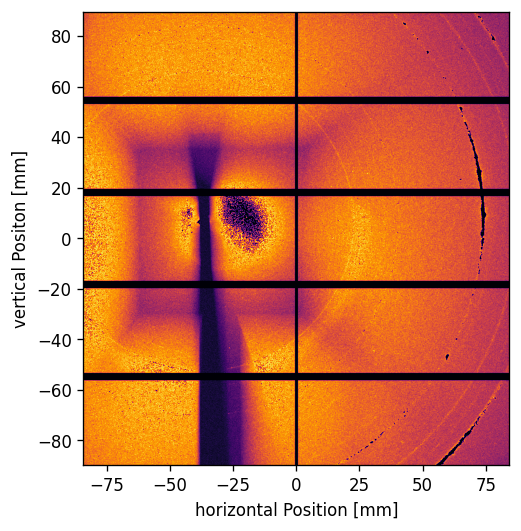

In [65]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/image_00144.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [86]:
# from A Hexemer

#E = 1239.8/lambda
#2d sin(theta) = lambda
#(200) 0.2024 nm-1
#(111) 0.2338 nm-1

# distance between sample and detector
sdd = 197 # milimeters

# center of the beam
center = np.array([276, 484]) #pixels

Al111 = 0.2338 #d-spacing of Al<111>
Al200 = 0.2024 #d-spacing of Al<200>
p111 = np.array([922, 466])
p200 = np.array([942, 60])

d111 = np.linalg.norm(center-p111)*0.172 # pixel size
theta111 = np.arctan(d111/sdd)/2.0
print(theta111/np.pi*180)
la111 = 2.0 * (Al111) * np.sin(theta111)
print(la111)
en = 1239.8/(la111)
print('Energy = '+str(en))

d200  = np.linalg.norm(center-p200)*0.172
theta200 = np.arctan(d200/sdd)/2.0
print(theta200/np.pi*180)
la200 = 2.0 * (Al200) * np.sin(theta200)
print(la200)
en = 1239.8/(la200)
print('Energy = '+str(en)+ ' eV')

14.71669771258321
0.11878902203256442
Energy = 10436.991388481381
17.289668712178905
0.12030765764023138
Energy = 10305.245936277008 eV


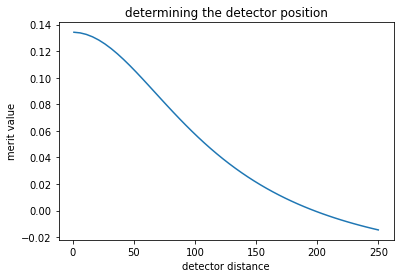

In [91]:
L_mm = np.linspace(1,250)
delta = np.sin(np.arctan(d111/L_mm))/np.sin(np.arctan(d200/L_mm))-Al200/Al111
plt.plot(L_mm,delta)
plt.title('determining the detector position')
plt.xlabel('detector distance')
plt.ylabel('merit value')
# retrieving detector spacing from two ringsplt.show()

In [94]:
# retrieving detector spacing from two rings

from scipy.optimize import fsolve

f = lambda L_mm: np.sin(np.arctan(d111/L_mm))/np.sin(np.arctan(d200/L_mm))-Al200/Al111 
x0 = 150 # 150 mm initial guess
Lopt_mm = fsolve(f, 150)
print('retieved detector distance [mm]: ' + str(Lopt_mm))

retieved detector distance [mm]: [197.43726895]


# Synchronizing mono motion with Pilatus reading

In [97]:
epics.caget('IOC:m1')

26.0

In [118]:
# monochromator scan
for i_s in np.arange(1):
    epics.caput('IOC:m1', 26)
    epics.caput('13PIL1:cam1:Acquire',1)


In [99]:
epics.caget('IOC:m1',1)

'26.0000'

In [106]:
from time import sleep as time_sleep
time_sleep(1)

In [177]:
theta0_deg = 25
dtheta_deg = 0.1

N_s = 11
theta_deg = np.zeros(N_s)

epics.caput('IOC:m1', theta0_deg)
time_sleep(2)

for i_s in np.arange(N_s):
    theta_deg[i_s] = theta0_deg + dtheta_deg*i_s
    epics.caput('IOC:m1', theta_deg[i_s])
    time_sleep(1)
    print(epics.caget('IOC:m1'))
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

25.0
25.1
25.2
25.3
25.4
25.5
25.6
25.7
25.8
25.9
26.0


# analyzing the data

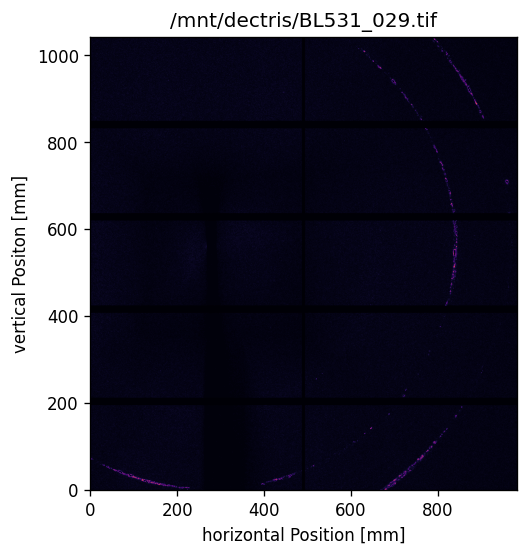

In [187]:
# make sure to transfer the data with sftp

last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
filepath = '/mnt/pilatus/' + last_filename[-14:-1]
filepath = '/mnt/dectris/BL531_029.tif' 
#filepath = '/mnt/pilatus/BL531_0028.tif'

im_tiff = Image.open(filepath)

im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
#extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels
extent = (0, +Nx_px, 0, Ny_px) #pixels

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.title(filepath)
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [188]:
from skimage.transform import warp, warp_polar

im_warp = warp_polar(im_np, center=[484,276])

# def azimuthal_avg(data_2d):
#     '''
#     AZIMUTHAL_AVG Azimuthal average of a 2D square image
#     azimuthal_avg(data_2d)
#     :param data_2d: square 2D numpy array
#     :return: numpy 1D array
#     '''
#     Np = int(np.floor((len(data_2d)+1)/2))
#     azimuthal_avg = np.sum(warp_polar(data_2d), 0)
#     return azimuthal_avg[0:(Np-1)]

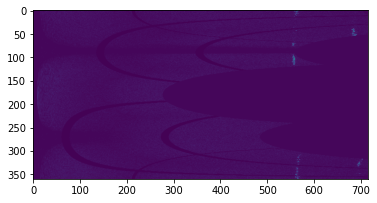

In [189]:
plt.imshow(im_warp)
plt.show()

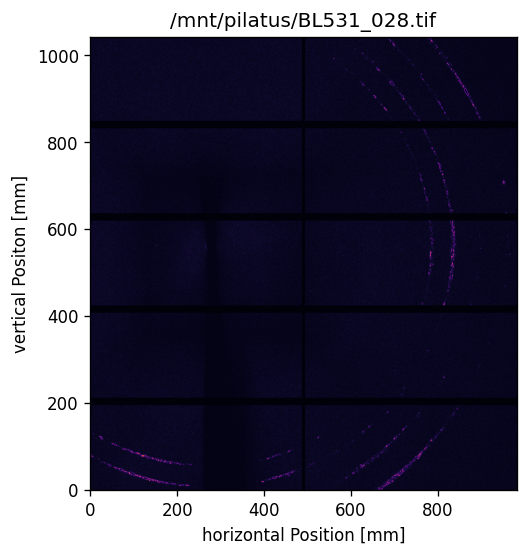

In [186]:
# make sure to transfer the data with sftp

last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
filepath = '/mnt/pilatus/' + last_filename[-14:-1]

filepath = '/mnt/pilatus/BL531_028.tif'

im_tiff = Image.open('/mnt/pilatus/BL531_019.tif')
im_np1 = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

im_np = im_np1+im_np2
# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
#extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels
extent = (0, +Nx_px, 0, Ny_px) #pixels

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.title('sum of images')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [278]:
!pip install pyFAI
!pip install opencv-python
!pip install scikit-image
import pyFAI
import cv2
import os
from skimage import io

def image_process(img):
    pilatus = pyFAI.detector_factory("Pilatus_1m")
    mask_pilatus = (pilatus.mask - 1.0) * (-1.0)
    nan_img = np.isnan(img)
    img_neg = (img < 0.0)
    mask_neg = np.array(img_neg)
    mask_nan = np.array(nan_img)
    mask_det = pilatus.mask 
    mask = ((mask_nan + mask_neg + mask_det))
    x = np.ma.array(img, mask = mask)
    img = img - np.min(x)
    x = np.ma.array(img, mask = mask)
    img = img / np.max(x)
    x = np.ma.array(img, mask = mask)
    img = np.log(x+0.000000000001)
    x = np.ma.array(img, mask = mask)
    img = img - np.min(x)
    x = np.ma.array(img, mask = mask)
    img = img / np.max(x) * 250.0
    mask = (mask - 1.0 )*(-1.0)
    img = img * mask
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(1,1))
    img = clahe.apply(img) 
    cv2.imwrite('test.jpg' ,img,[cv2.IMWRITE_JPEG_QUALITY, 100])  

    return img

def image_process_no_log(img):
    pilatus = pyFAI.detector_factory("Pilatus_1m")
    mask_pilatus = (pilatus.mask - 1.0) * (-1.0)
    nan_img = np.isnan(img)
    img_neg = (img < 0.0)
    mask_neg = np.array(img_neg)
    mask_nan = np.array(nan_img)
    mask_det = pilatus.mask 
    mask = ((mask_nan + mask_neg + mask_det))
    x = np.ma.array(img, mask = mask)
    img = img - np.min(x)
    x = np.ma.array(img, mask = mask)
    img = img / np.max(x)
    x = np.ma.array(img, mask = mask)
    #img = np.log(x+0.000000000001)
    x = np.ma.array(img, mask = mask)
    img = img - np.min(x)
    x = np.ma.array(img, mask = mask)
    img = img / np.max(x) * 250.0
    mask = (mask - 1.0 )*(-1.0)
    img = img * mask
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(1,1))
    img = clahe.apply(img) 
    return img

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_3024376/1142882851.py:23: RuntimeWarning: invalid value encountered in log
  img = np.log(x+0.000000000001)


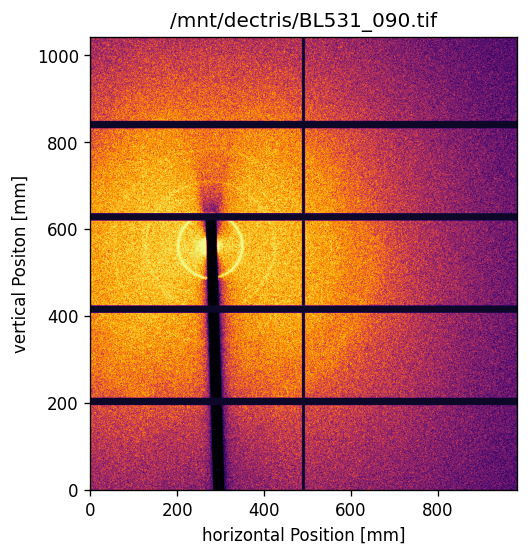

In [279]:
import time 

epics.caput('13PIL1:cam1:Acquire',1)
time.sleep(5)

last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
filepath = '/mnt/dectris/' + (bytes(last_filename_ascii).decode())[-14:-1]
im_tiff = Image.open(filepath)

image_test = io.imread(filepath)

new_image = image_process(image_test)


im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
#extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels
extent = (0, +Nx_px, 0, Ny_px) #pixels
plt.imshow(new_image, extent=extent, cmap = 'inferno')
plt.title(filepath)
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()


# Main energy loop

In [292]:
theta0_deg = 25
dtheta_deg = 0.1

N_s = 31
theta_deg = np.zeros(N_s)

epics.caput('IOC:m1', theta0_deg)
time_sleep(2)

images = ()
for i_s in np.arange(N_s):
    theta_deg[i_s] = theta0_deg + dtheta_deg*i_s
    epics.caput('IOC:m1', theta_deg[i_s])
    time_sleep(1)
    #print(epics.caget('IOC:m1'))
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

    # fetch image
    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    filepath = '/mnt/dectris/' + (bytes(last_filename_ascii).decode())[-14:-1]
    #print(filepath)
    img = io.imread(filepath)
    images += (img,)

25.0
/mnt/dectris/BL531_102.tif
25.1
/mnt/dectris/BL531_103.tif
25.2
/mnt/dectris/BL531_104.tif
25.3
/mnt/dectris/BL531_105.tif
25.4
/mnt/dectris/BL531_106.tif
25.5
/mnt/dectris/BL531_107.tif
25.6
/mnt/dectris/BL531_108.tif
25.7
/mnt/dectris/BL531_109.tif
25.8
/mnt/dectris/BL531_110.tif
25.9
/mnt/dectris/BL531_111.tif
26.0
/mnt/dectris/BL531_112.tif
26.1
/mnt/dectris/BL531_113.tif
26.2
/mnt/dectris/BL531_114.tif
26.3
/mnt/dectris/BL531_115.tif
26.4
/mnt/dectris/BL531_116.tif
26.5
/mnt/dectris/BL531_117.tif
26.6
/mnt/dectris/BL531_118.tif
26.7
/mnt/dectris/BL531_119.tif
26.8
/mnt/dectris/BL531_120.tif
26.9
/mnt/dectris/BL531_121.tif
27.0
/mnt/dectris/BL531_122.tif
27.1
/mnt/dectris/BL531_123.tif
27.2
/mnt/dectris/BL531_124.tif
27.3
/mnt/dectris/BL531_125.tif
27.4
/mnt/dectris/BL531_126.tif
27.5
/mnt/dectris/BL531_127.tif
27.6
/mnt/dectris/BL531_128.tif
27.7
/mnt/dectris/BL531_129.tif
27.8
/mnt/dectris/BL531_130.tif
27.9
/mnt/dectris/BL531_131.tif
28.0
/mnt/dectris/BL531_132.tif


/tmp/ipykernel_3024376/1142882851.py:23: RuntimeWarning: invalid value encountered in log
  img = np.log(x+0.000000000001)


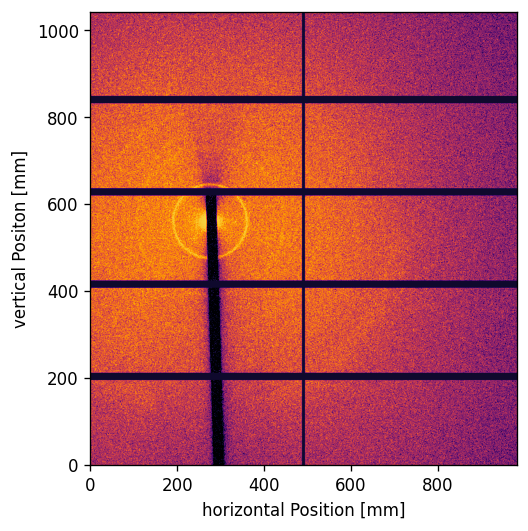

In [314]:
image_test = images[-1]

new_image = image_process(image_test)

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
#extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels
extent = (0, +Nx_px, 0, Ny_px) #pixels
plt.imshow(new_image, extent=extent, cmap = 'inferno')
#plt.title(filepath)
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()



In [293]:
from skimage.transform import warp, warp_polar
img_sum = ()
for image in images:
    #new_image = image_process_no_log(image)
    new_image = image
    im_warp = warp_polar(new_image, center=[484,276])
    #plt.imshow(im_warp)
    #plt.show()
    img_sum += (im_warp,)


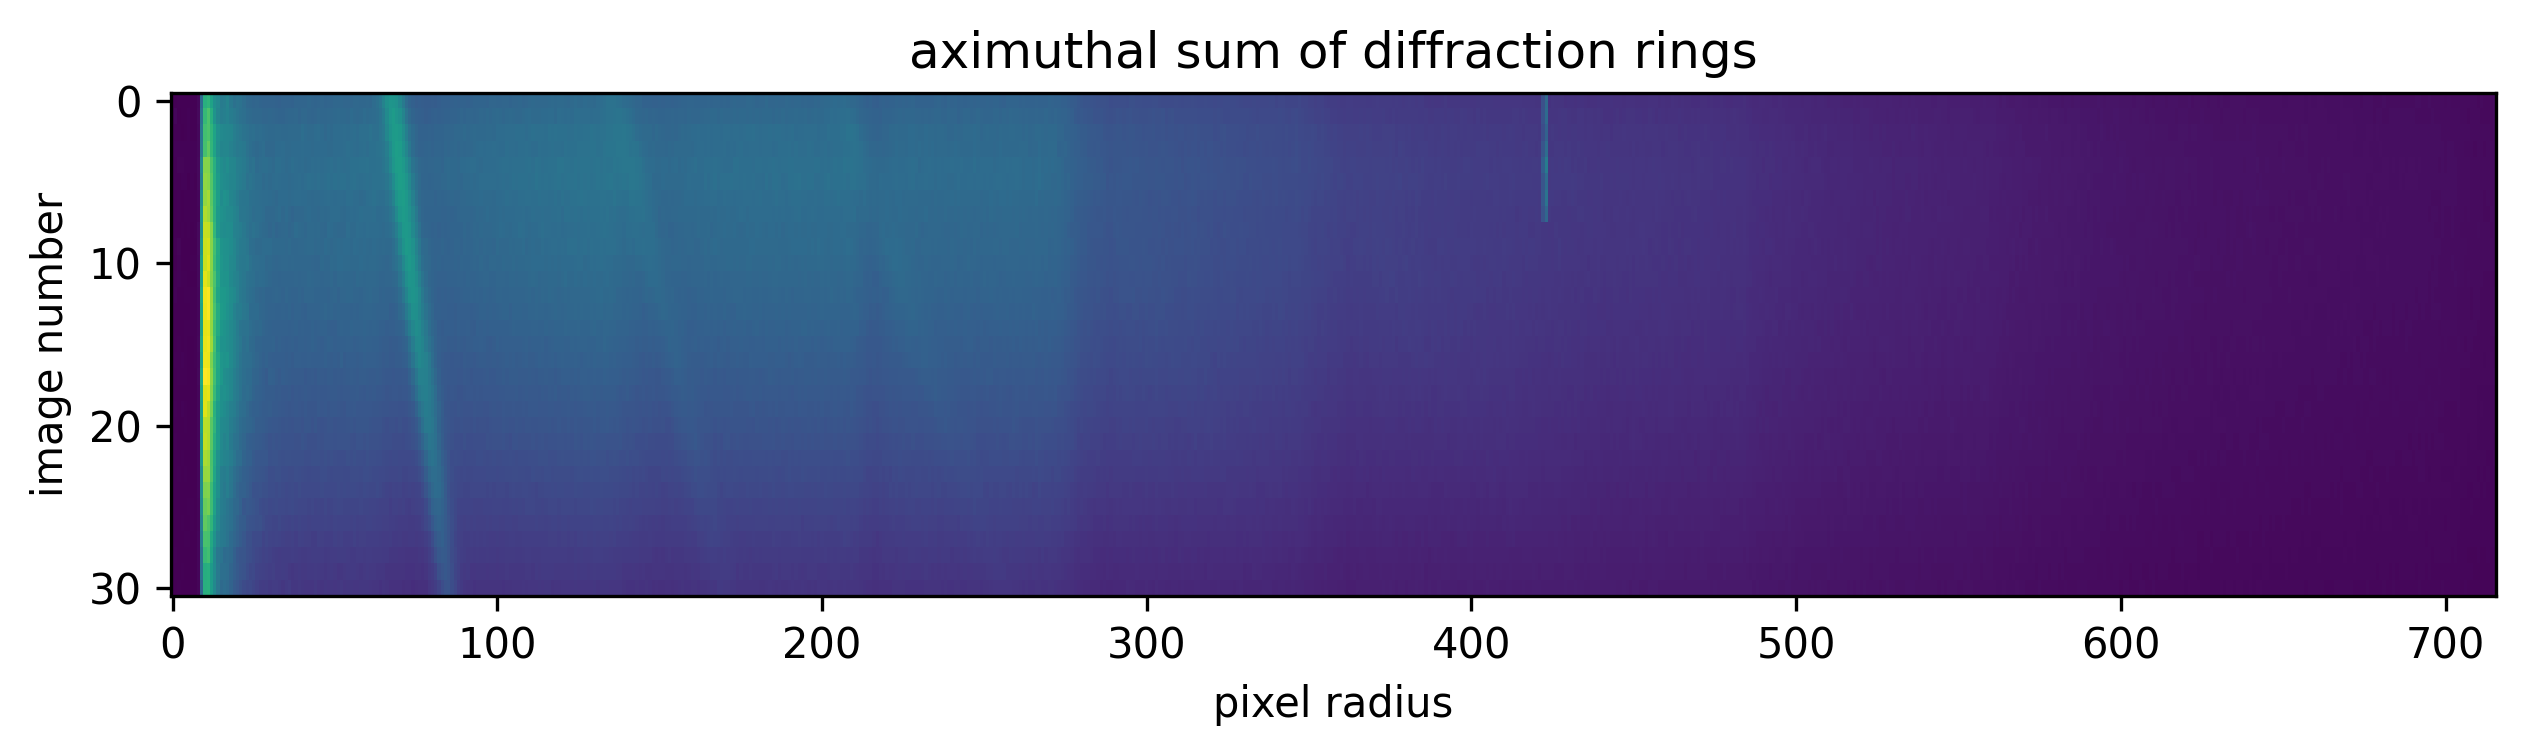

In [312]:
fig=plt.figure(figsize=(10, 10), dpi= 300, facecolor='w', edgecolor='k')
plt.imshow(np.sum(img_sum,axis=1), aspect=5)
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')
#plt.imshow(np.sum(np.sum(img_sum,axis=1),axis=0))

plt.show()